# Matrix Analysis notebook

Here's a collection of function to analyse matrix data, correlation and statistiques.
Computation is cell-wise

By Kaciel Béraud and Canelle Lepillier

GNU General Public License v3

## Installation of dependencies

Since the `openchord` dependency is quite unstable, it's prefered to use python's `virtual environment`. You will have to open a terminal or a powershell.

Linux/Mac:

```
python3 -m venv openchord # create the environment
source openchord/bin/activate # activate it
pip install ipykernel ipywidgets numpy pandas tables scipy matplotlib seaborn openchord # install the packages
python -m ipykernel install --user --name=openchord # install it for jupyter
```
Windows:

```
py -m venv openchord # create the environment
openchord\Scripts\activate # activate it
py -m pip install ipykernel ipywidgets numpy pandas tables scipy matplotlib seaborn openchord # install the packages
ipython kernel install --user --name=openchord # install it for jupyter
```

This procedure suppose you have python already installed and ready to use.

## Usage

We suppose the files are `csv`, modification can be done to support `excel` files, see [Pandas' documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) for more.

One can load a single file with the function `load` or a directory containing multiples files with `load_directory`. It can be used as follow: 

```
csv = load("path/to/file.csv", ",")

# OR

csv_list = load_directory("path/to/directory/", ",")

### to show a matrix
display(csv)

# OR

display(csv[0])
```

Then using the result of the loading function, one can use the statistics function to work on them. One function can ask or either a single file or a list of files. Do not hesitate to read the description next to the function for more information!

```
mean_matrix = mean(csv_list)

std_matrix = std(csv_list_)
```

Then you can plot the result with a simple function:

```
plot(csv)

# With some arguments
plot(csv, title = "My title", save = "path/to/save", show = False, vmin = -0.25, vmax = 4)

# to show the significant P-value:

plot_p(csv)
```

And finally a function to show the correlation using a chord representation:

```
f = chord(csv)
f.show() # due to limitation in the library, to show them in the notebook, you have to do this
```

This function take a lot of arguments to tweak the plot, you can pass then when calling the `chord` function.

**But beware!** If NaN (Not a Number) value are in the matrix, the representation will fail!

## Settings

In [1]:
# Imports
import pandas as pd
import numpy as np
import openchord as ocd
from scipy import stats
import glob
import os
import seaborn
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [2]:
# Value
P_VALUE = 0.05
SKEW = 1

## Functions

We defines the function used here, there is loading, saving, statistics and plotting functions.

In [3]:
'''
function to load the csv
path_ is the path of a file. ONLY ONE
delimiter_ is the delimiter in the csv file, like ','
the returned object is a pandas DataFrame
'''
def load(path_, delimiter_) :
    
    csv = pd.read_csv(path_, delimiter = delimiter_)
    csv.set_index('Row', inplace = True)
    
    return csv

'''
function to load a whole directory
same as load
'''
def load_directory(path_, delimiter_) :

    # fetch every file that match
    files = glob.glob(os.path.join(path_,'*.csv'))
    files.sort()

    # stop the programm if the directory is empty
    if len(files) == 0 :
        raise Exception('The directory you want to load is empty, are you sure you this is not a typo?')

    # use list comprehension because it's cleaner
    # cannot use map here directly, a list and a single argument
    list_files = [load(f, delimiter_) for f in files]
        
    return list_files

'''
Allow you to write the csv on the disk
the csv_ is the dataframe
name_ is the path and name, like 'my/folder/soup.csv'
'''
def save(csv_, name_) :

    # it's pretty self explanatory don't you think?
    csv_.to_csv(name_, sep = ',')
    
    return

### COMPUTATION ###

### Useful

'''
function to transform the dataframe
into a numpy matrix.
For maths purpose
but loose the labels
matrix_ is the dataframe from "load" function
TODO: return a copy of the labels to put them again after
'''
def to_numpy(matrix_) :
    
    np_matrix = matrix_.to_numpy()
    
    return np_matrix

'''
function to transform the numpy array
back to a dataframe
matrix_ is a numpy array
and header_ is the name of the columns/rows. It need to start with 'Row'
'''
def to_df(matrix_, header_) :

    df = pd.DataFrame(matrix_, columns = header_)
    df['Row'] = pd.Series(header_)
    df.set_index('Row', inplace = True)

    return df

'''
Transform a list of numpy array matrix into a list of cell
Allow the applications of statistical test
The lenght of the list is equal to the shape of the matrix
'''
def to_list(matrix_list_) :
    
    shape = matrix_list_[0].shape
    length = len(matrix_list_)

    # big ugly 3D matrix that will store every cell
    # first and second identier should be the same place
    # the third is the position of the initial list
    output_list = [[[0.0] * length] * shape[0]] * shape[1]
    output_list = np.array(output_list)

    for l in range(length) :
        for x in range(shape[0]) :
            for y in range(shape[1]) :
                output_list[x][y][l] = matrix_list_[l][y][x] # swapping x and y here do not matter, symmetrical matrix

    return output_list

'''
Function to rename the labels in the matrix.
Takes a matrix and the new labels as a list or a dictionnary.
'''
def rename(matrix_, labels_) :

    # make a dictionnary if it's a list
    if isinstance(labels_, list) :
        label_list = matrix_.columns.to_list()
        if len(label_list) != len(labels_) :
            raise ValueError("The number of labels passed mismatch the number of labels in the matrix! IF you want to rename only some labels, use the dictionnary form! See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html")
        labels = {}
        for prev, new in zip(label_list, labels_) :
            labels[prev] = new
    else :
        labels = labels

    df = matrix_.rename(index = labels, columns = labels)
    
    return df

'''
Function to reorder the labels in both column and line way.
This can also remove unwanted columns and lines if they are not present in the label list
Takes a matrix and the labels in the new order.
'''
def reorder(matrix_, labels_) : 

    df = matrix_[labels_]
    df = df.loc[labels_]

    return df

'''
Drop the column and index given as input
Takes a matrix and the labels to remove, string or list.
'''
def drop(matrix_, labels_) :

    df = matrix_.drop(index = labels_, columns = labels_)
    
    return df

### Statistics

'''
Compute the mean of a list of matrix
the csv_list_ is a list of pandas dataframe
from the function "load"
'''
def mean(csv_list_) :

    # convert internally the dataframe to matrix
    np_list = [to_numpy(csv) for csv in csv_list_]

    # compute the mean
    mean_mat = np.zeros(np_list[0].shape)
    for mat in np_list :
        mean_mat = mean_mat + mat
    mean_mat = mean_mat / len(csv_list_)

    # convert again to a dataframe
    mean_df = to_df(mean_mat, list(csv_list_[0]))
    
    return mean_df
    

'''
Compute the standard deviation of a list of matrix
the csv_list_ is a list of pandas dataframe
from the function "load"
'''
def std(csv_list_) :

    np_list = [to_numpy(csv) for csv in csv_list_]

    mean_mat = mean(csv_list_) # it's a dataframe

    std_mat = np.zeros(np_list[0].shape)
    for i in range(len(np_list)) :
        std_mat += np_list[i] ** 2
    std_mat = np.sqrt( 1 / len(np_list) * std_mat - mean_mat ** 2)

    # No need to convert back to dataframe, the line above converted it because the mean matrix is in fact a pandas dataframe
    # std_df = to_df(std_mat, list(csv_list_[0]))

    return std_mat


'''
a function to compute the fisher's z-transformation of a matrix
The z is the inverse hyperbolic tangent function or the pearson correlation coefficient. 
'''
def fisher_transform(csv_) :

    # into numpy
    csv = to_numpy(csv_)

    # compute
    z_fisher = np.arctanh(csv)

    # into dataframe
    z_fisher_df = to_df(z_fisher, list(csv_))

    return z_fisher_df

'''
Same as before, but for a list of matrix
'''
def fisher_transform_list(list_csv_) :

    # using map here because it's faster
    list_fisher = list(map(fisher_transform, list_csv_))

    return list_fisher

'''
Shapiro-Wilk to test the normality of data.
Take an array of Dataframe after a fisher transform
Returns a matrix with the stats and another with the p-value.
Normally distributed with p > 0.05
'''
def shapiro(csv_list_) :

    # a list of numpy
    numpy_list = [to_numpy(f) for f in csv_list_]

    # a 2D matrix of list for the math
    math_matrix = to_list(numpy_list)

    # Results
    stat_matrix = np.zeros([math_matrix.shape[0], math_matrix.shape[1]])
    p_matrix = np.zeros([math_matrix.shape[0], math_matrix.shape[1]])

    # computation
    for x in range(math_matrix.shape[0]) :
        for y in range(math_matrix.shape[1]) :
            stat_matrix[y][x], p_matrix[y][x] = stats.shapiro(math_matrix[x][y])
            
    # into dataframe
    stat_df = to_df(stat_matrix, list(csv_list_[0]))
    p_df = to_df(p_matrix, list(csv_list_[0]))

    return stat_df, p_df

'''
test to check if the data distribution is symmetrical
Take an array of Dataframe after a fisher transform
Returns skew df
'''
def skew(csv_list_) :

    # a list of numpy
    numpy_list = [to_numpy(f) for f in csv_list_]

    # a 2D matrix of lists for math
    math_matrix = to_list(numpy_list)

    # Results
    skew_matrix = np.zeros([math_matrix.shape[0], math_matrix.shape[1]])

    # computation
    for x in range(math_matrix.shape[0]) :
        for y in range(math_matrix.shape[1]) :
            skew_matrix[y][x] = stats.skew(math_matrix[x][y])
            
    # into dataframe
    skew_df = to_df(skew_matrix, list(csv_list_[0]))

    return skew_df

'''
Main function to compare the H0 hypotesis
for 2 dependant sample group.
Take a list of dataframe from the 'load_directory' function
Returns a matrix with the stats, the p-value and one with the test used.
'''
def two_dependant_samples(group_1_, group_2_) :

    # Check if the groups have the same size
    if len(group_1_) != len(group_2_) :
        raise Exception('The two groups should have the same length!')

    ### Preparation of the data
    # Fisher transform
    fisher_group_1 = fisher_transform_list(group_1_)
    fisher_group_2 = fisher_transform_list(group_2_)

    # Normality
    s, normality_group_1 = shapiro(fisher_group_1)
    s, normality_group_2 = shapiro(fisher_group_2)

    # Matrix of list for the maths
    matrix_group_1 = to_list([to_numpy(csv) for csv in fisher_group_1])
    matrix_group_2 = to_list([to_numpy(csv) for csv in fisher_group_2])
    normality_group_1 = to_numpy(normality_group_1)
    normality_group_2 = to_numpy(normality_group_2)

    # differences betweens the two groups
    differences_np = [to_numpy(group_2_[x]) - to_numpy(group_1_[x]) for x in range(len(group_1_))] # list of numpy matrix
    differences_df = [to_df(f, list(group_1_[0])) for f in differences_np] # list of dataframes
    differences_list = to_list(differences_np) # single 3D matrix for math purpose

    # skewness
    skew_df = skew(differences_df)
    skew_np = to_numpy(skew_df)
    
    # Results
    stat_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])
    p_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])
    test_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])

    # Tree test
    for x in range(matrix_group_1.shape[0]) :
        for y in range(matrix_group_1.shape[1]) :
            if normality_group_1[y][x] < P_VALUE and normality_group_2[y][x] < P_VALUE : # dependant t-test
                    results = stats.ttest_rel(matrix_group_1[x][y], matrix_group_2[x][y])
                    stat_matrix[y][x] = results[0]
                    p_matrix[y][x] = results[1]
                    test_matrix[y][x] = 1
            else :
                if abs(skew_np[y][x]) < SKEW : # the difference between the two related groups is symmetrical in shape  # Wilcoxon
                    results = stats.wilcoxon(matrix_group_1[x][y], matrix_group_2[x][y]) 
                    stat_matrix[y][x] = results[0]
                    p_matrix[y][x] = results[1]
                    test_matrix[y][x] = 2
                else : # Sign test (or paired-sample sign test)
                    dif = differences_list[y][x]
                    
                    dif = dif[dif != 0] # remove any potential 0 dif
                    if len(dif) == 0 : # take care of the diagonals
                        continue
                    
                    # cutting the negatives and positives
                    dif_neg = np.sum(dif < 0)
                    dif_pos = np.sum(dif > 0)


                    # evaluate which array is the smallest
                    n = np.min([dif_pos, dif_neg])
                    

                    binom = stats.binomtest(n, n = dif_pos + dif_neg)
                    p_matrix[y][x] = binom.pvalue
                    stat_matrix[y][x] = binom.statistic
                    
                    test_matrix[y][x] = 3

    # into dataframe
    stat_df = to_df(stat_matrix, list(group_1_[0]))
    p_df = to_df(p_matrix, list(group_1_[0]))
    test_matrix = to_df(test_matrix, list(group_1_[0]))
    
    return stat_df, p_df, test_matrix


'''
Main function to compare the H0 hypotesis
for 2 independant sample group.
Take a list of dataframe from the 'load_directory' function
Returns a matrix with the stats, the p-value and one with the test used.
'''
def two_independant_samples(group_1_, group_2_, trim_ = 0.1) :

    # Fisher transform
    fisher_group_1 = fisher_transform_list(group_1_)
    fisher_group_2 = fisher_transform_list(group_2_)

    # Normality
    s, normality_group_1 = shapiro(fisher_group_1)
    s, normality_group_2 = shapiro(fisher_group_2)

    # Variance 
    # variance_group_1 = levene(fisher_group_1)
    # variance_group_2 = levene(fisher_group_2)
    s, variance_group = levene(fisher_group_1, fisher_group_2)

    # Matrix of list for the maths
    matrix_group_1 = to_list([to_numpy(csv) for csv in fisher_group_1])
    matrix_group_2 = to_list([to_numpy(csv) for csv in fisher_group_2])
    variance_group = to_numpy(variance_group)
    normality_group_1 = to_numpy(normality_group_1)
    normality_group_2 = to_numpy(normality_group_2)
    
    # Results
    stat_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])
    p_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])
    test_matrix = np.zeros([matrix_group_1.shape[0], matrix_group_1.shape[1]])

    # Tree test
    for x in range(matrix_group_1.shape[0]) :
        for y in range(matrix_group_1.shape[1]) :
            if variance_group[y][x] < P_VALUE : 
                if normality_group_1[y][x] < P_VALUE and normality_group_2[y][x] < P_VALUE : # independant t-test
                    results = stats.ttest_ind(matrix_group_1[x][y], matrix_group_2[x][y])
                    stat_matrix[y][x] = results[0]
                    p_matrix[y][x] = results[1]
                    test_matrix[y][x] = 1
                else : # Mann-Whitney's test
                    stat_matrix[y][x], p_matrix[y][x] = stats.mannwhitneyu(matrix_group_1[x][y], matrix_group_2[x][y])
                    test_matrix[y][x] = 2
            else :
                if normality_group_1[y][x] < P_VALUE and normality_group_2[y][x] > P_VALUE : # Welch's t-test
                    results = stats.ttest_ind(matrix_group_1[x][y], matrix_group_2[x][y], equal_var = False) 
                    stat_matrix[y][x] = results[0]
                    p_matrix[y][x] = results[1]
                    test_matrix[y][x] = 3
                else : # Yuen-Welch's test
                    results = stats.ttest_ind(matrix_group_1[x][y], matrix_group_2[x][y], equal_var = False, trim = trim_) 
                    stat_matrix[y][x] = results[0]
                    p_matrix[y][x] = results[1]
                    test_matrix[y][x] = 4

    # into dataframe
    stat_df = to_df(stat_matrix, list(group_1_[0]))
    p_df = to_df(p_matrix, list(group_1_[0]))
    test_matrix = to_df(test_matrix, list(group_1_[0]))
    
    return stat_df, p_df, test_matrix


### Plot

'''
Plot function allowing to draw any matrix.
Take a dataframe outputed by any function
'''
def plot(df_, title = None, save = None, show = True, vmax = 1, vmin = -1, colormap = "bwr") :

    fig, ax = plt.subplots(figsize=(8.5, 7), squeeze=True)
    hm = seaborn.heatmap(df_, cmap = colormap, square = True, vmin = vmin, vmax = vmax)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    if title is not None :
        fig.suptitle(title)
    
    if save is not None :
        plt.savefig(save)

    if show :
        plt.show()

    return


'''
Plot function allowing to draw any matrix.
Take a dataframe outputed by any function
Especially the p value matrix, dark out the non significatives cells
'''
def plot_p(df_, title = None, save = None, show = True, dark = True) :

    # custom colormap
    mat = to_numpy(df_)
    vmin = np.nanmin(mat)
    vmax = np.nanmax(mat)
    point = int(256/(vmax-vmin) * P_VALUE)

    # use viridis as a placeholder
    viridis = mpl.colormaps['viridis'].resampled(256) # 256 values
    newcolors = viridis(np.linspace(0, 1, 256))
    black = np.array([0, 0, 0, 1])
    white = np.array([1, 1, 1, 1])
    if dark :
        newcolors[:point, :] = white
        newcolors[point:, :] = black
    else :
        newcolors[:, :] = white
        
    newcmp = ListedColormap(newcolors)


    fig, ax = plt.subplots(figsize=(8.5, 7), squeeze=True)
    hm = seaborn.heatmap(df_, cmap = newcmp, annot = True, square = True, annot_kws = {'size':'x-small','color': 'black'}, fmt = ',.2f', cbar = False)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    if title is not None :
        fig.suptitle(title)
    
    if save is not None :
        plt.savefig(save)

    if show :
        plt.show()

    return

'''
Fonction to draw a chord filled diagramm
Use the openChord library.
Take the dataframe and the name as how the file need to be saved
The other optionnals arguments are described.
The image is saved as a SVG, you may have to convert it to a PNG to use it anywhere.
'''


def chord(df_, 
          name = None,
          radius = 300, # size of the circle
          padding = 40, # spacing between objects
          font_size = 10, # font size
          font_family = "Times New Roman", # font family
          background = "#000000", # background color
          transparancy = 0, # background transparancy
          arc_thickness = 0.05, # thickness of the arc line
          rotation = 12.5,
          x = -600, # position in x
          y = -500, # position in y
          w = 2000, # width in pixels
          h = 1000, # height in pixels
          text_position = 0.1, # text position
          gap_size = 0.1, # size of the gap between the arcs
          ribbon_gap = 0.01, # the gap between the ribbons
          ribbon_stiffness = 0.1, # the stiffness of the arc, aka how round they will be
          colormap = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'] # the colormap for the graph
          ) :


    matrix = to_numpy(df_)

    labels = list(df_)
    
    # The core of the chord diagram
    fig = ocd.Chord(matrix, labels)

    ### changing details
    # colormap:
    fig.colormap = colormap
    
    # background color:
    '''
    Default = white 100% opaque
    To make color use "bg_color":
    To make transparent use "bg_transparancy":
    '''
    fig.bg_color = background
    fig.bg_transparancy = transparancy
    
    # radius:
    '''
    OpenChord draws using the Scalable Vector Graphics (SVG) format,
    so the plots have infinite resolution.
    But we have to specify how large we want the plot to appear on screen.
    The default radius is 200 pixels.
    '''
    fig.radius = radius # may not be really useful if we do not show the graphs
    
    # padding:
    '''
    The radius is actually the inner radius of the chord diagram.
    If there is no padding, the image gets cut off.
    The default padding value is 50 pixels.
    '''
    fig.padding = padding
    
    # font:
    fig.font_size = font_size
    fig.font_family = font_family
    
    # rotation:
    '''
    conversion_rate converts the weights to arc length
    '''
    fig.rotation = rotation * fig.conversion_rate

    # custom plot area:
    fig.plot_area = {"x": x, "y": y, "w": w, "h": h}

    # gradient style:
    '''
    the default gradient style based on edges of the ribbons work in most case.
    but if it doesnt we can use "midpoint",
    where the gradient is computed on the mid point of the arc:
    fig.gradient_style = "midpoint"
    '''
    
    # arc thickness:
    '''
    is specified as a proportion of the radius. Default is 0.07.
    '''
    fig.arc_thickness = arc_thickness
    
    # text position:
    '''
    the text position is specified as a proportion of the radius.
    default value is 0.1.
    '''
    fig.text_position = text_position

    # gap size:
    '''
    the gap_size attribute controls the gaps between the arcs.
    The default value is 0.01 radian.
    '''
    fig.gap_size = gap_size
    
    # ribbon gap:
    '''
    the ribbon gap is also specified as a proportion of the radius.
    default thickness is 0.01.
    '''
    fig.ribbon_gap = ribbon_gap
    
    # ribbon stiffness:
    '''
    default is 0.6
    '''
    fig.ribbon_stiffness = ribbon_stiffness

    if name is not None :
        fig.save_svg(name if name.endswith(".svg") else name + ".svg")

    return fig

## Compute

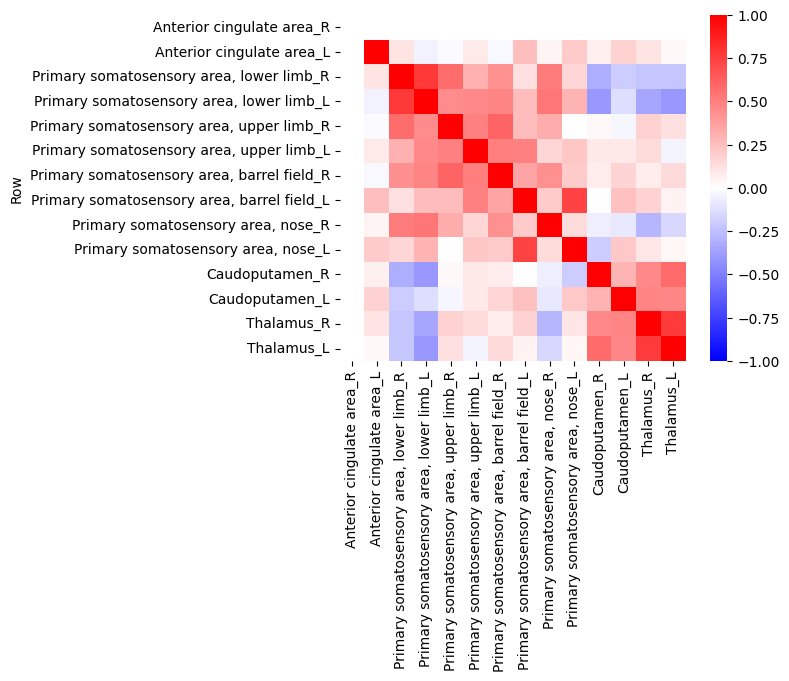

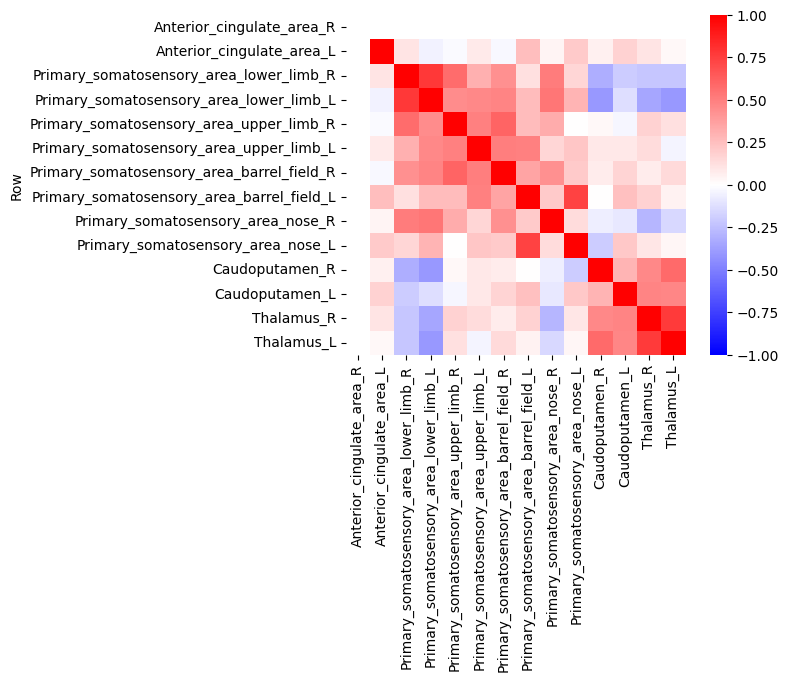

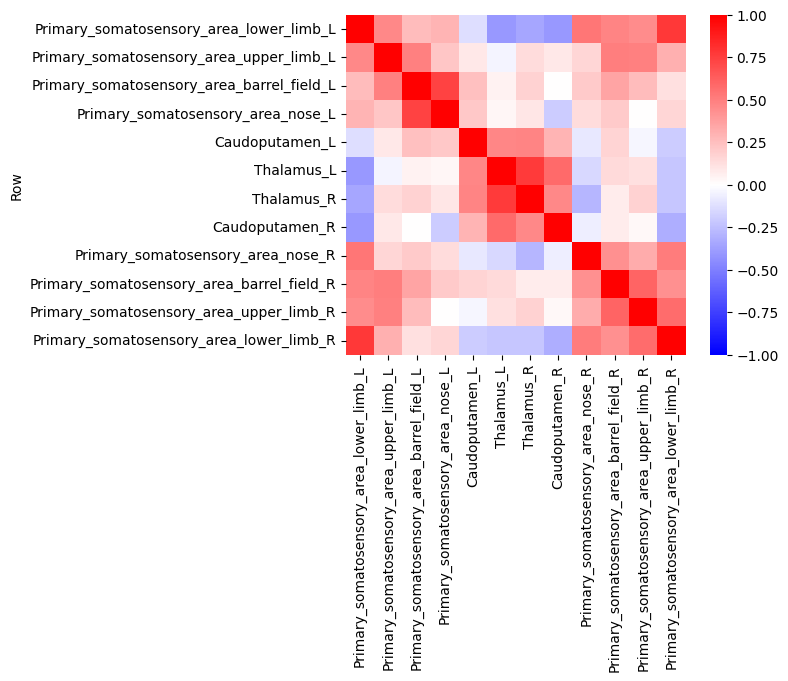

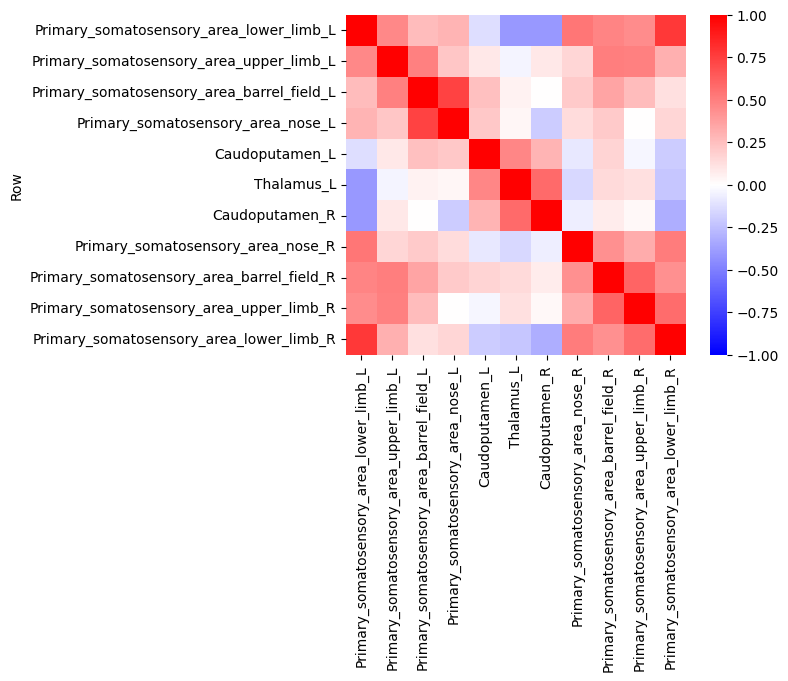

In [6]:
csv = load("matrix.csv", ",")

plot(csv)

# Remove the lines with NaN
csv.drop("Anterior cingulate area_R", axis = 0, inplace = True)
csv.drop("Anterior cingulate area_R", axis = 1, inplace = True)

original_labels = ['Anterior_cingulate_area_R', 'Anterior_cingulate_area_L',
       'Primary_somatosensory_area_lower_limb_R',
       'Primary_somatosensory_area_lower_limb_L',
       'Primary_somatosensory_area_upper_limb_R',
       'Primary_somatosensory_area_upper_limb_L',
       'Primary_somatosensory_area_barrel_field_R',
       'Primary_somatosensory_area_barrel_field_L',
       'Primary_somatosensory_area_nose_R',
       'Primary_somatosensory_area_nose_L', 'Caudoputamen_R',
       'Caudoputamen_L', 'Thalamus_R', 'Thalamus_L']

# to dataframe (df)
labels = [
    #'Anterior_cingulate_area_L', 
    'Primary_somatosensory_area_lower_limb_L', 
    'Primary_somatosensory_area_upper_limb_L', 
    'Primary_somatosensory_area_barrel_field_L', 
    'Primary_somatosensory_area_nose_L', 
    'Caudoputamen_L', 
    'Thalamus_L', 
    'Thalamus_R', 
    'Caudoputamen_R', 
    'Primary_somatosensory_area_nose_R', 
    'Primary_somatosensory_area_barrel_field_R', 
    'Primary_somatosensory_area_upper_limb_R', 
    'Primary_somatosensory_area_lower_limb_R', 
    #'Anterior_cingulate_area_R'
         ]

new_csv = rename(csv, original_labels)

plot(new_csv)

new_csv = reorder(new_csv, labels)

plot(new_csv)

new_csv = drop(new_csv, "Thalamus_R")

plot(new_csv)

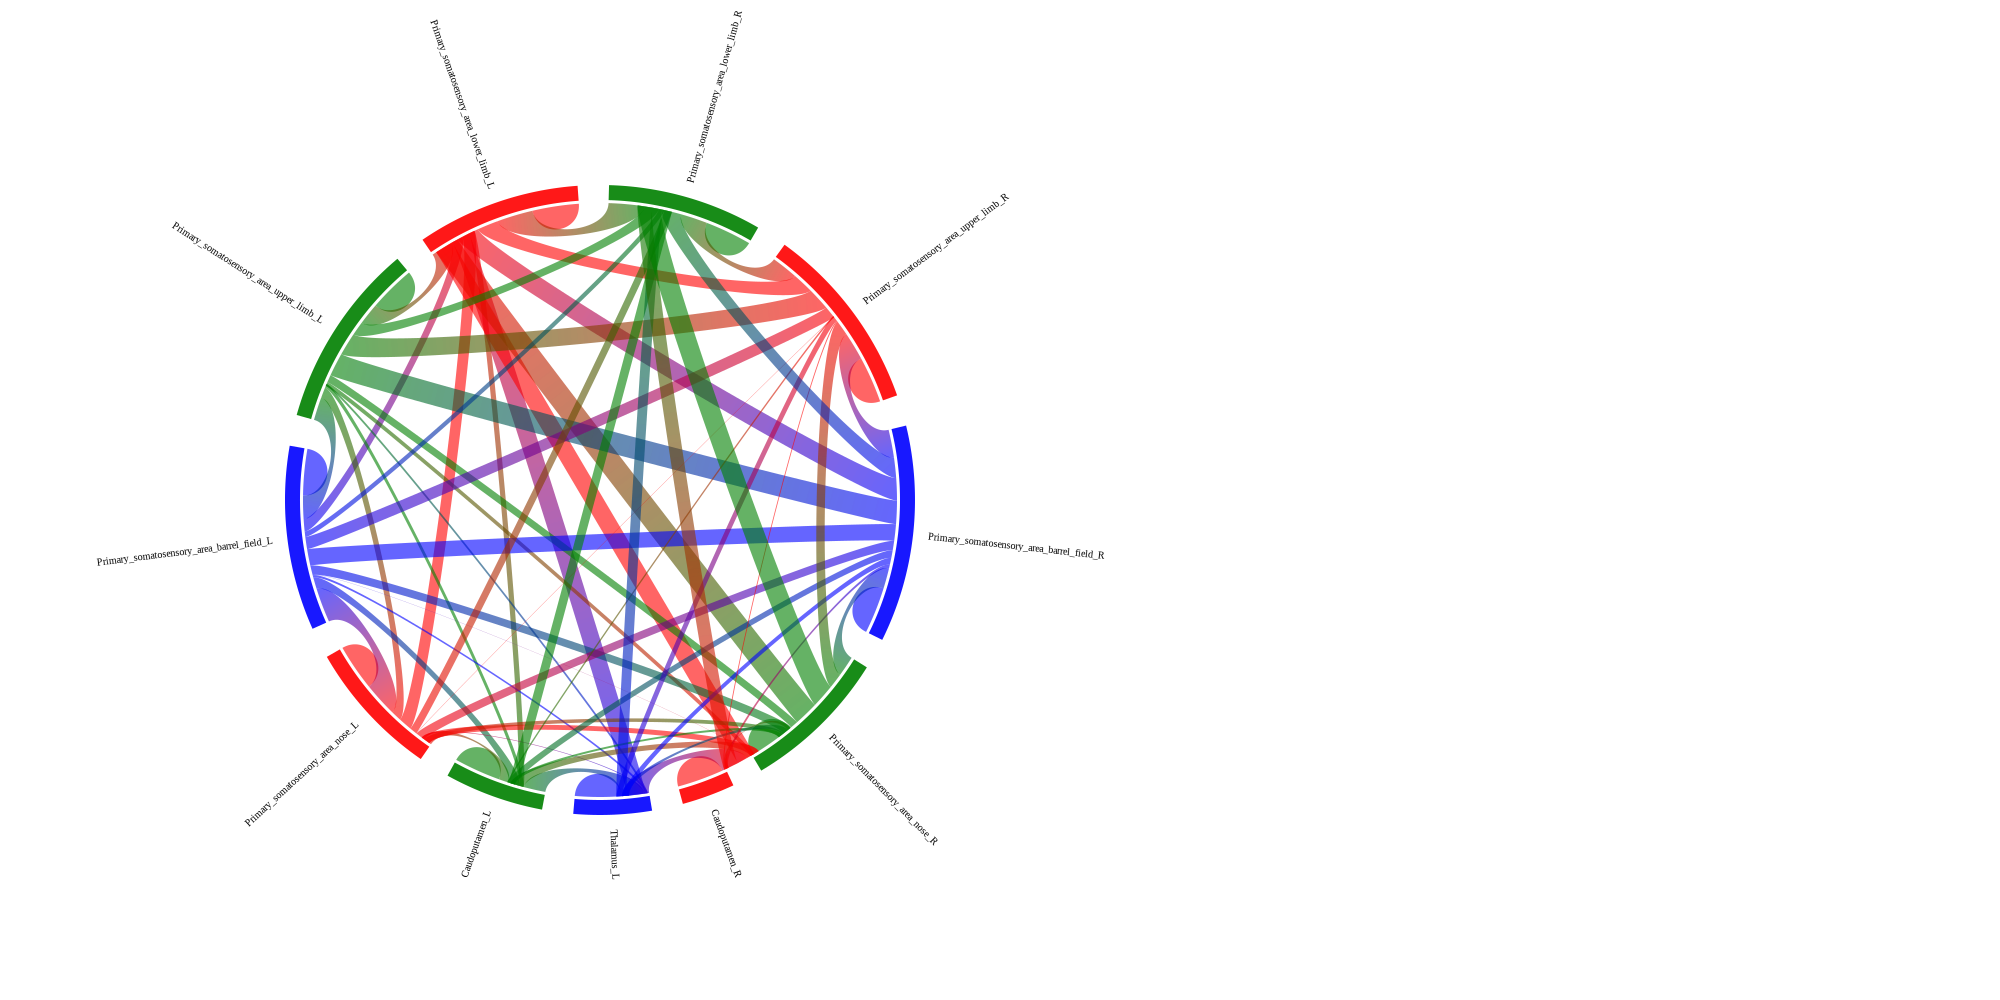

In [21]:
f = chord(new_csv, 
          rotation = 8.7,
          colormap = ["red", "green", "blue"],
          name = "test")
f.show()